In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

import warnings
warnings.filterwarnings('ignore')

In [103]:
df = pd.read_csv('bikes_rent.csv')
duplicates=df.duplicated()
print(duplicates)# дубликатов нет
df=df.dropna()
df.info()
df.head()

0      False
1      False
2      False
3      False
4      False
       ...  
726    False
727    False
728    False
729    False
730    False
Length: 731, dtype: bool
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   season          731 non-null    object 
 1   mnth            731 non-null    int64  
 2   holiday         731 non-null    int64  
 3   weekday         731 non-null    object 
 4   weathersit      731 non-null    object 
 5   temp            731 non-null    float64
 6   atemp           731 non-null    float64
 7   hum             731 non-null    float64
 8   windspeed(mph)  731 non-null    float64
 9   windspeed(ms)   731 non-null    float64
 10  cnt             731 non-null    int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 62.9+ KB


,season,mnth,holiday,weekday,weathersit,temp,atemp,hum,windspeed(mph),windspeed(ms),cnt
0,spring,1,0,sun,cloudy,14.1108470000,18.1812500000,80.5833000000,10.7498820000,4.8054903889,985
1,spring,1,0,mon,cloudy,14.9025980000,17.6869500000,69.6087000000,16.6521130000,7.4439485919,801
2,spring,1,0,tue,sunny,8.0509240000,9.4702500000,43.7273000000,16.6367030000,7.4370599016,1349
3,spring,1,0,wed,sunny,8.2000000000,10.6061000000,59.0435000000,10.7398320000,4.8009977649,1562
4,spring,1,0,thu,sunny,9.3052370000,11.4635000000,43.6957000000,12.5223000000,5.5978095664,1600


In [104]:
#формируем целевую переменную и выборки.

target=df['cnt']
features=df.drop(['cnt'],axis=1)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=.25, random_state=123456) 

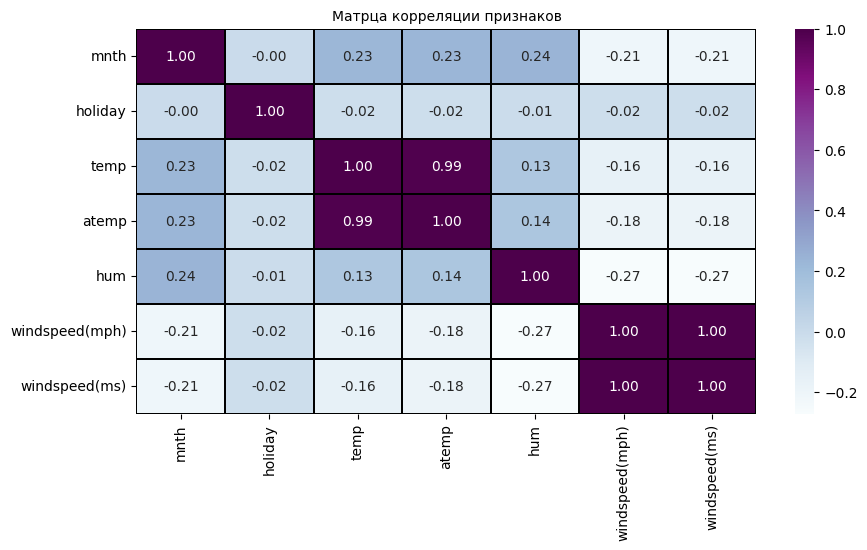

In [105]:
# проверим корреляцию признаков
plt.figure(figsize=(10, 5))
correlation_matrix = features_train.corr(numeric_only=True)
plt.title('Матрца корреляции признаков', fontsize = 10)
sns.heatmap(correlation_matrix, 
            linewidths=0.1,
            linecolor='black',
            annot=True, 
            fmt='.2f', 
            cmap='BuPu')
plt.show()
features_train.columns = features_train.columns.astype(str)
features_test.columns = features_test.columns.astype(str)

это матрица корелляции признаком без учета категориальных, мы видим, что некоторые признаки сильно кореллируют с другими-средняя тмпература с обычной, и скорости ветра в разных метриках. Позже мы удилм эти признаки и посмотрим, будет ли это влиять на результаты.

In [106]:
#создаем функцию расчета метрик модели

df_model = pd.DataFrame({'Model name': [],'RMSE': [], 'MAPE %': [], 'R2': []})
pd.options.display.float_format ='{:,.10f}'.format
    
def model_char(test, pred, df, model_name):
    
    rmse = mean_squared_error(test, pred)**0.5
    mape = mean_absolute_percentage_error(test, pred)
    r2 = r2_score(test, pred)
    df_model.loc[len(df_model.index )] = [model_name, rmse, mape*100, r2]
    
    return df_model

In [107]:
# построим модель линейной регрессии без учета категориальных признаков
numeric = ['mnth', 'holiday', 'temp', 'atemp','hum','windspeed(mph)','windspeed(ms)']

model = LinearRegression()
model.fit(features_train[numeric], target_train)
predictions = model.predict(features_test[numeric]) 

model_char(target_test, predictions, df_model, 'LinearRegression')

,Model name,RMSE,MAPE %,R2
0,LinearRegression,"1,355.8891601472",33.4026057065,0.5002682850


Масштаб данных разный, размерность площади сильно отличается от остальных признаков.
Применим стандартизацию данных и проверим, повлияет ли это на качество модели.

In [108]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])

In [109]:
model.fit(features_train[numeric], target_train)
predictions_scaler = model.predict(features_test[numeric]) 

model_char(target_test, predictions_scaler, df_model, 'LinearRegression scaler')



,Model name,RMSE,MAPE %,R2
0,LinearRegression,"1,355.8891601472",33.4026057065,0.5002682850
1,LinearRegression scaler,"1,355.8866789794",33.4025297423,0.5002701139


Cтандартизация данных не повлияла на качество модели.

Добавим в модель категориальные признаки применив метод OneHotEncoder.

In [110]:

category=['season','weekday','weathersit']
encoder=OneHotEncoder(drop='first')
encoder.fit(features_train[category])

encoder_train = pd.DataFrame(encoder.transform(features_train[category]).toarray(), index=features_train.index)
encoder_test = pd.DataFrame(encoder.transform(features_test[category]).toarray(), index=features_test.index)

features_train = features_train.join(encoder_train)
features_train.drop(category, axis= 1 , inplace= True )

features_test = features_test.join(encoder_test)
features_test.drop(category, axis= 1 , inplace= True )

features_train.columns = features_train.columns.astype(str)
features_test.columns = features_test.columns.astype(str)

In [112]:
model.fit(features_train, target_train)
predictions_encoder = model.predict(features_test) 

model_char(target_test, predictions_encoder, df_model, 'LinearRegression encoder')

,Model name,RMSE,MAPE %,R2
0,LinearRegression,"1,355.8891601472",33.4026057065,0.5002682850
1,LinearRegression scaler,"1,355.8866789794",33.4025297423,0.5002701139
2,LinearRegression encoder,"1,274.2957419808",31.1967100883,0.5586033844
3,LinearRegression encoder,"1,274.2957419808",31.1967100883,0.5586033844


Добавление категориальных признаков повлияло на качество модели, добавив 5%. Не сказать, что это очень большое изменение, но уже что-то.

In [113]:
#Применим регуляризацию Лассо

model_lasso = Lasso(alpha=0.9)
model_lasso.fit(features_train, target_train)

predictions_lasso = model_lasso.predict(features_test) 

model_char(target_test, predictions_lasso, df_model, 'LinearRegression Lasso')

,Model name,RMSE,MAPE %,R2
0,LinearRegression,"1,355.8891601472",33.4026057065,0.5002682850
1,LinearRegression scaler,"1,355.8866789794",33.4025297423,0.5002701139
2,LinearRegression encoder,"1,274.2957419808",31.1967100883,0.5586033844
3,LinearRegression encoder,"1,274.2957419808",31.1967100883,0.5586033844
4,LinearRegression Lasso,"1,268.8661475969",31.1829171948,0.5623568283


In [114]:
# выведем коэффициенты регулиризованной модели
pd.DataFrame(model_lasso.coef_, 
             features_test.columns, 
             columns=["coef"]).sort_values(by="coef", 
                                           ascending=False)

,coef
temp,"1,246.3588138194"
2,"1,057.2604549713"
1,367.3875247834
5,323.5075827239
6,268.4837607297
10,260.2107457603
8,102.3667628135
4,93.0323931509
7,90.9971055124
windspeed(ms),-0.0000000000


In [115]:
#Применим гребневую регуляризацию 

model_Ridge = Ridge(alpha=0.9)
model_Ridge.fit(features_train, target_train)

predictions_Ridge = model_lasso.predict(features_test) 

model_char(target_test, predictions_lasso, df_model, 'LinearRegression Ridge')

,Model name,RMSE,MAPE %,R2
0,LinearRegression,"1,355.8891601472",33.4026057065,0.5002682850
1,LinearRegression scaler,"1,355.8866789794",33.4025297423,0.5002701139
2,LinearRegression encoder,"1,274.2957419808",31.1967100883,0.5586033844
3,LinearRegression encoder,"1,274.2957419808",31.1967100883,0.5586033844
4,LinearRegression Lasso,"1,268.8661475969",31.1829171948,0.5623568283
5,LinearRegression Ridge,"1,268.8661475969",31.1829171948,0.5623568283


In [116]:
# построим прогноз константной моделью
model_dummy = DummyRegressor(strategy='median')
model_dummy.fit(features_train[numeric], target_train)
predictions_dummy = model_dummy.predict(features_test[numeric])

model_char(target_test, predictions_dummy, df_model, 'DummyRegressor')

,Model name,RMSE,MAPE %,R2
0,LinearRegression,"1,355.8891601472",33.4026057065,0.5002682850
1,LinearRegression scaler,"1,355.8866789794",33.4025297423,0.5002701139
2,LinearRegression encoder,"1,274.2957419808",31.1967100883,0.5586033844
3,LinearRegression encoder,"1,274.2957419808",31.1967100883,0.5586033844
4,LinearRegression Lasso,"1,268.8661475969",31.1829171948,0.5623568283
5,LinearRegression Ridge,"1,268.8661475969",31.1829171948,0.5623568283
6,DummyRegressor,"1,922.7058688014",56.6848601158,-0.0048800839


In [117]:
df_model.sort_values(by='R2', ignore_index=True)

,Model name,RMSE,MAPE %,R2
0,DummyRegressor,"1,922.7058688014",56.6848601158,-0.0048800839
1,LinearRegression,"1,355.8891601472",33.4026057065,0.5002682850
2,LinearRegression scaler,"1,355.8866789794",33.4025297423,0.5002701139
3,LinearRegression encoder,"1,274.2957419808",31.1967100883,0.5586033844
4,LinearRegression encoder,"1,274.2957419808",31.1967100883,0.5586033844
5,LinearRegression Lasso,"1,268.8661475969",31.1829171948,0.5623568283
6,LinearRegression Ridge,"1,268.8661475969",31.1829171948,0.5623568283


Регуляризация не особо влияет на улушение миодели, всего 1%

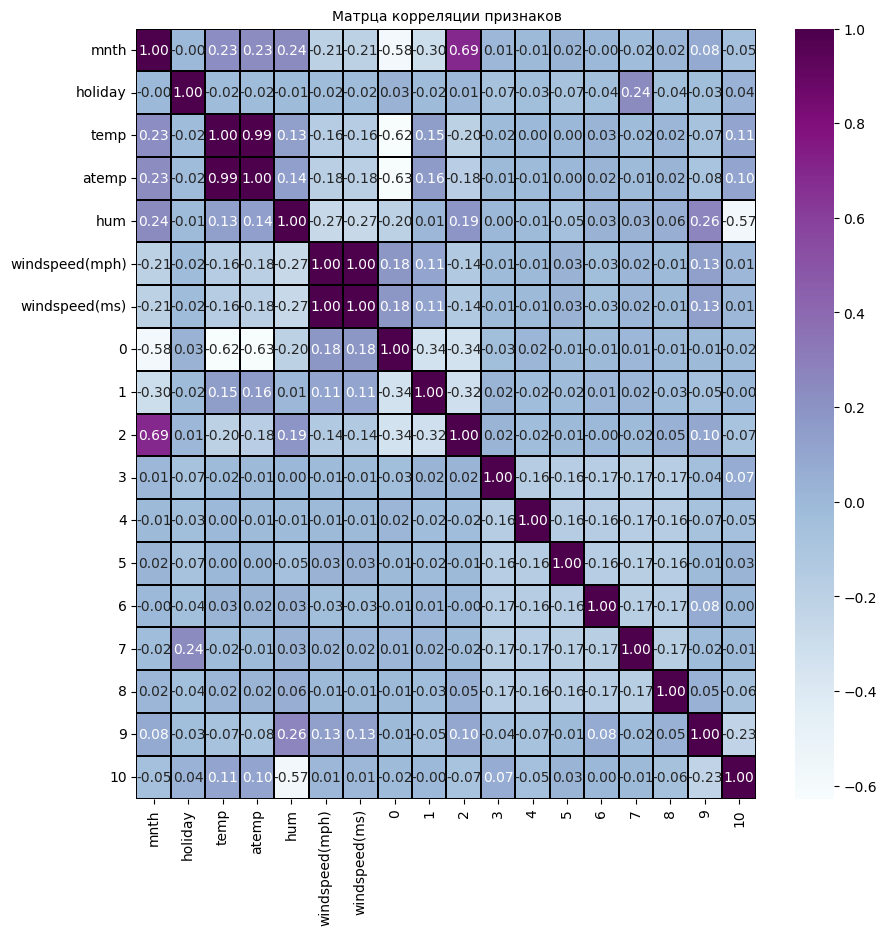

In [118]:
plt.figure(figsize=(10, 10))
correlation_matrix = features_train.corr()
plt.title('Матрца корреляции признаков', fontsize = 10)
sns.heatmap(correlation_matrix, 
            linewidths=0.1,
            linecolor='black',
            annot=True, 
            fmt='.2f', 
            cmap='BuPu')
plt.show()


Теперь мы удалим коррелирующие признаки, првоедем те же самые тесты и проверям, насколько улучшиться(или ухудшиться) модель

In [119]:
df.info()
df.drop('temp', axis=1, inplace=True)
df.drop('windspeed(mph)', axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   season          731 non-null    object 
 1   mnth            731 non-null    int64  
 2   holiday         731 non-null    int64  
 3   weekday         731 non-null    object 
 4   weathersit      731 non-null    object 
 5   temp            731 non-null    float64
 6   atemp           731 non-null    float64
 7   hum             731 non-null    float64
 8   windspeed(mph)  731 non-null    float64
 9   windspeed(ms)   731 non-null    float64
 10  cnt             731 non-null    int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 62.9+ KB


In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 731 entries, 0 to 730
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   season         731 non-null    object 
 1   mnth           731 non-null    int64  
 2   holiday        731 non-null    int64  
 3   weekday        731 non-null    object 
 4   weathersit     731 non-null    object 
 5   atemp          731 non-null    float64
 6   hum            731 non-null    float64
 7   windspeed(ms)  731 non-null    float64
 8   cnt            731 non-null    int64  
dtypes: float64(3), int64(3), object(3)
memory usage: 51.5+ KB


In [121]:
target=df['cnt']
features=df.drop(['cnt'],axis=1)
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=.25, random_state=123456) 

In [122]:
#создаем функцию расчета метрик модели

df_model = pd.DataFrame({'Model name': [],'RMSE': [], 'MAPE %': [], 'R2': []})
pd.options.display.float_format ='{:,.10f}'.format
    
def model_char(test, pred, df, model_name):
    
    rmse = mean_squared_error(test, pred)**0.5
    mape = mean_absolute_percentage_error(test, pred)
    r2 = r2_score(test, pred)
    df_model.loc[len(df_model.index )] = [model_name, rmse, mape*100, r2]
    
    return df_model

In [123]:
# построим модель линейной регрессии без учета категориальных признаков
numeric = ['mnth', 'holiday',  'atemp','hum','windspeed(ms)']

model = LinearRegression()
model.fit(features_train[numeric], target_train)
predictions = model.predict(features_test[numeric]) 

model_char(target_test, predictions, df_model, 'LinearRegression')

,Model name,RMSE,MAPE %,R2
0,LinearRegression,"1,340.2613131560",33.2921580513,0.5117216160


как мы видим, первоначальная модель работает на 1% лучше, чем до этого, значит, что коррелирующие признаки хоть немного но все таки создавли шум.

In [124]:
scaler = StandardScaler()
scaler.fit(features_train[numeric])

features_train[numeric] = scaler.transform(features_train[numeric])
features_test[numeric] = scaler.transform(features_test[numeric])
model.fit(features_train[numeric], target_train)
predictions_scaler = model.predict(features_test[numeric]) 

model_char(target_test, predictions_scaler, df_model, 'LinearRegression scaler')

,Model name,RMSE,MAPE %,R2
0,LinearRegression,"1,340.2613131560",33.2921580513,0.5117216160
1,LinearRegression scaler,"1,340.2613131560",33.2921580513,0.5117216160


Cтандартизация данных не повлияла на качество модели.

Добавим в модель категориальные признаки применив метод OneHotEncoder.

In [125]:
category=['season','weekday','weathersit']
encoder=OneHotEncoder(drop='first')
encoder.fit(features_train[category])

encoder_train = pd.DataFrame(encoder.transform(features_train[category]).toarray(), index=features_train.index)
encoder_test = pd.DataFrame(encoder.transform(features_test[category]).toarray(), index=features_test.index)

features_train = features_train.join(encoder_train)
features_train.drop(category, axis= 1 , inplace= True )

features_test = features_test.join(encoder_test)
features_test.drop(category, axis= 1 , inplace= True )

features_train.columns = features_train.columns.astype(str)
features_test.columns = features_test.columns.astype(str)

In [126]:
model.fit(features_train, target_train)
predictions_encoder = model.predict(features_test) 

model_char(target_test, predictions_encoder, df_model, 'LinearRegression encoder')

,Model name,RMSE,MAPE %,R2
0,LinearRegression,"1,340.2613131560",33.2921580513,0.5117216160
1,LinearRegression scaler,"1,340.2613131560",33.2921580513,0.5117216160
2,LinearRegression encoder,"1,256.4377426265",31.1099061206,0.5708881748


после добавления категориальных признаком модель довольно неплохо улучшилась, даже лучше чем до удаления "шумных" признаков, в категорильных признаков не было кореллирующих,возможно это и повлияло на немного улучшенный результат.

In [127]:
model_lasso = Lasso(alpha=0.9)
model_lasso.fit(features_train, target_train)

predictions_lasso = model_lasso.predict(features_test) 

model_char(target_test, predictions_lasso, df_model, 'LinearRegression Lasso')

,Model name,RMSE,MAPE %,R2
0,LinearRegression,"1,340.2613131560",33.2921580513,0.5117216160
1,LinearRegression scaler,"1,340.2613131560",33.2921580513,0.5117216160
2,LinearRegression encoder,"1,256.4377426265",31.1099061206,0.5708881748
3,LinearRegression Lasso,"1,254.7541420622",31.1311462587,0.5720374062


In [128]:
# выведем коэффициенты регулиризованной модели
pd.DataFrame(model_lasso.coef_, 
             features_test.columns, 
             columns=["coef"]).sort_values(by="coef", 
                                           ascending=False)

,coef
atemp,"1,076.6076319221"
2,841.9079635144
5,321.9867233640
6,292.5260967535
10,270.8633540878
1,219.2544452065
4,135.8813305088
8,107.1187633897
7,82.3054268508
3,-9.8701947620


In [129]:
model_Ridge = Ridge(alpha=0.9)
model_Ridge.fit(features_train, target_train)

predictions_Ridge = model_lasso.predict(features_test) 

model_char(target_test, predictions_lasso, df_model, 'LinearRegression Ridge')

,Model name,RMSE,MAPE %,R2
0,LinearRegression,"1,340.2613131560",33.2921580513,0.5117216160
1,LinearRegression scaler,"1,340.2613131560",33.2921580513,0.5117216160
2,LinearRegression encoder,"1,256.4377426265",31.1099061206,0.5708881748
3,LinearRegression Lasso,"1,254.7541420622",31.1311462587,0.5720374062
4,LinearRegression Ridge,"1,254.7541420622",31.1311462587,0.5720374062


Регуляризация не дала результатов, как и в прошлый раз


In [130]:
# построим прогноз константной моделью
model_dummy = DummyRegressor(strategy='median')
model_dummy.fit(features_train[numeric], target_train)
predictions_dummy = model_dummy.predict(features_test[numeric])

model_char(target_test, predictions_dummy, df_model, 'DummyRegressor')

,Model name,RMSE,MAPE %,R2
0,LinearRegression,"1,340.2613131560",33.2921580513,0.5117216160
1,LinearRegression scaler,"1,340.2613131560",33.2921580513,0.5117216160
2,LinearRegression encoder,"1,256.4377426265",31.1099061206,0.5708881748
3,LinearRegression Lasso,"1,254.7541420622",31.1311462587,0.5720374062
4,LinearRegression Ridge,"1,254.7541420622",31.1311462587,0.5720374062
5,DummyRegressor,"1,922.7058688014",56.6848601158,-0.0048800839


In [131]:
df_model.sort_values(by='R2', ignore_index=True)

,Model name,RMSE,MAPE %,R2
0,DummyRegressor,"1,922.7058688014",56.6848601158,-0.0048800839
1,LinearRegression,"1,340.2613131560",33.2921580513,0.5117216160
2,LinearRegression scaler,"1,340.2613131560",33.2921580513,0.5117216160
3,LinearRegression encoder,"1,256.4377426265",31.1099061206,0.5708881748
4,LinearRegression Lasso,"1,254.7541420622",31.1311462587,0.5720374062
5,LinearRegression Ridge,"1,254.7541420622",31.1311462587,0.5720374062


# Выводы
Данная модель линейной регрессии показывает точность 57%(максимум). После того, как мы избавились от сильно кореллирующих признаков, все стало немного получше, что говорит о том, что мы убрали лишний шум. Так же на модель сильно повлияли категориальные признаки, когда мы их добавили, модель заметно улучшилась, что говорит о том, что много категорильных признаков в данных были явно не шумом. регуляризация нам не очень помогла в обоих случаях(в первом немного улучшила, во втором совсем минимально улучшила), что говорит о том, что:в первом слцучае-она смогла определить"шум" и неинформативные признаки, во втором случае